In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import torch
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Force reload modules
import importlib
import ppn2v.pn2v.gaussianMixtureNoiseModel
import ppn2v.pn2v.histNoiseModel
import ppn2v.pn2v.training
importlib.reload(ppn2v.pn2v.gaussianMixtureNoiseModel)
importlib.reload(ppn2v.pn2v.histNoiseModel)
importlib.reload(ppn2v.pn2v.training)

from ppn2v.unet.model import UNet
from ppn2v.pn2v import utils
from ppn2v.pn2v import gaussianMixtureNoiseModel
from ppn2v.pn2v import histNoiseModel
from ppn2v.pn2v import training
from tifffile import imread

Using device: cpu


### Configure Training

In [2]:
# Path to prepared data
path = './'

# Data name (must match previous notebooks)
dataName = 'dataset01'

# Load training data (noisy image)
data = imread(path + f'{dataName}_noisy.tif')
print(f"Training data shape: {data.shape}")
print(f"Training data range: [{data.min():.4f}, {data.max():.4f}]")

Training data shape: (1, 128, 128)
Training data range: [0.0000, 255.0000]


In [3]:
# SELECT NOISE MODEL
# GMM is recommended for better generalization

# Option 1: Histogram noise model
# nameNoiseModel = f'HistNoiseModel_{dataName}_calibration'

# Option 2: GMM noise model (RECOMMENDED)
nameNoiseModel = f'GMMNoiseModel_{dataName}_3_2_calibration'

print(f"Using noise model: {nameNoiseModel}")

Using noise model: GMMNoiseModel_dataset01_3_2_calibration


In [4]:
# Load the noise model
namePN2VModel = nameNoiseModel

if 'HistNoiseModel' in nameNoiseModel:
    histogram = np.load(path + nameNoiseModel + '.npy')
    noiseModel = histNoiseModel.NoiseModel(histogram, device=device)
    print("Loaded histogram noise model")
    
elif 'GMMNoiseModel' in nameNoiseModel:
    params = np.load(path + nameNoiseModel + '.npz')
    noiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(
        params=params, device=device
    )
    print("Loaded GMM noise model")
    print(f"  Signal range: [{noiseModel.min_signal:.4f}, {noiseModel.max_signal:.4f}]")
    print(f"  Gaussians: {noiseModel.n_gaussian}")

Loaded GMM noise model
  Signal range: [0.0000, 127.0000]
  Gaussians: 3


### Create PN2V Network

**Key settings:**
- `n_channels=800`: Number of samples from the prior (affects uncertainty estimation)
- `depth=3`: Standard U-Net depth
- `start_filts=64`: Standard channel count (supervisor used 4 to prevent hallucinations)

In [5]:
# PN2V Network Architecture
n_samples = 800      # Number of output samples (for uncertainty estimation)
depth = 3            # U-Net depth
start_filts = 64     # Starting filter count (standard = 64, supervisor used 4)

# Create network
net = UNet(n_samples, depth=depth)

# Count parameters
total_params = sum(p.numel() for p in net.parameters())
trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print(f"Network Architecture:")
print(f"  Output samples: {n_samples}")
print(f"  Depth: {depth}")
print(f"  Start filters: {start_filts}")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

Network Architecture:
  Output samples: 800
  Depth: 3
  Start filters: 64
  Total parameters: 1,729,313
  Trainable parameters: 1,729,313


### Prepare Training Data

Since we have only 1 image, we'll use the same image for training and validation.
This is acceptable because:
1. N2V-style training uses random pixel masking (different pixels each epoch)
2. We're evaluating on a separate clean image anyway

In [6]:
# With single image, use same for train and val
# The random masking ensures different pixels are used each time
my_train_data = data.copy()
my_val_data = data.copy()

print(f"Training data shape: {my_train_data.shape}")
print(f"Validation data shape: {my_val_data.shape}")
print(f"\nNote: Using same image for train/val is OK because:")
print(f"  1. Random pixel masking ensures different samples each epoch")
print(f"  2. Final evaluation uses separate clean_image.tif")

Training data shape: (1, 128, 128)
Validation data shape: (1, 128, 128)

Note: Using same image for train/val is OK because:
  1. Random pixel masking ensures different samples each epoch
  2. Final evaluation uses separate clean_image.tif


### Train PN2V

**Training time estimate:**
- GPU: ~10-20 minutes
- CPU: ~1-2 hours

Reduce `numOfEpochs` if you want faster results for initial testing.

In [12]:
# Training configuration
# Adjust numOfEpochs based on your time budget:
#   - Quick test: 30 epochs
#   - Standard: 100 epochs  
#   - Best quality: 200 epochs

numOfEpochs = 20    # Balanced between quality and time
stepsPerEpoch = 5   # Steps per epoch
batchSize = 1        # Batch size (1 for single image)
learningRate = 1e-3  # Learning rate

print(f"Training Configuration:")
print(f"  Epochs: {numOfEpochs}")
print(f"  Steps/epoch: {stepsPerEpoch}")
print(f"  Batch size: {batchSize}")
print(f"  Learning rate: {learningRate}")
print(f"\nEstimated time: {'~30-60 min on CPU' if device.type == 'cpu' else '~10-20 min on GPU'}")

Training Configuration:
  Epochs: 20
  Steps/epoch: 5
  Batch size: 1
  Learning rate: 0.001

Estimated time: ~30-60 min on CPU


In [13]:
# Start training
# Note: Training progress is printed automatically by the training function
# You will see: "Epoch X finished", "avg. loss: ...", "Epoch time: ..."
import sys

print("="*60)
print("Starting PN2V training...")
print(f"Target: {numOfEpochs} epochs, ~{numOfEpochs * 0.5:.0f} minutes on CPU")
print("="*60)
sys.stdout.flush()

trainHist, valHist = training.trainNetwork(
    net=net,
    trainData=my_train_data,
    valData=my_val_data,
    postfix=namePN2VModel,
    directory=path,
    noiseModel=noiseModel,  # PN2V uses noise model!
    device=device,
    numOfEpochs=numOfEpochs,
    stepsPerEpoch=stepsPerEpoch,
    virtualBatchSize=20,
    batchSize=batchSize,
    learningRate=learningRate
)

print("="*60)
print("Training complete!")
print("="*60)

Starting PN2V training...
Target: 20 epochs, ~10 minutes on CPU
Start training
Start training
Epoch 0 finished      
avg. loss: 5.555559372901916+-(2SEM)0.0017588123622676946      
Epoch 0 finished      
avg. loss: 5.555559372901916+-(2SEM)0.0017588123622676946      
Epoch time: 3.5020164251327515 min      
Epoch time: 3.5020164251327515 min      
Finished step 9/5      
Epoch 1 finished      
avg. loss: 5.55541455745697+-(2SEM)0.001067884554124846      
Epoch time: 13.894121023019155 min      
Finished step 9/5      
Epoch 1 finished      
avg. loss: 5.55541455745697+-(2SEM)0.001067884554124846      
Epoch time: 13.894121023019155 min      
Epoch 2 finished      
avg. loss: 5.555903458595276+-(2SEM)0.0013746891230857056      
Epoch time: 11.297346385320028 min      
Epoch 2 finished      
avg. loss: 5.555903458595276+-(2SEM)0.0013746891230857056      
Epoch time: 11.297346385320028 min      
Epoch 3 finished      
avg. loss: 5.55570170879364+-(2SEM)0.001759371833795168      
Epoch tim

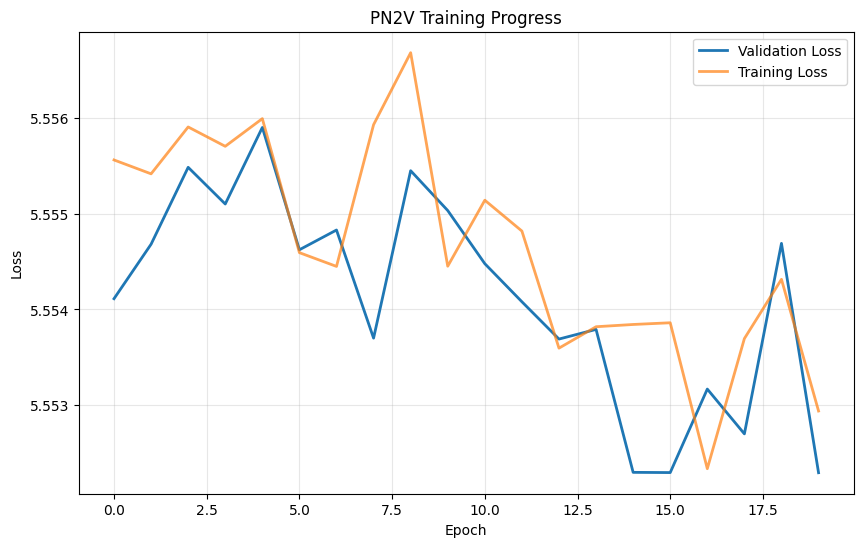

Initial training loss: 5.555559
Final training loss: 5.552940
Final validation loss: 5.552296
Best validation loss: 5.552296 (epoch 19)


In [14]:
# Plot training progress
plt.figure(figsize=(10, 6))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(valHist, label='Validation Loss', linewidth=2)
plt.plot(trainHist, label='Training Loss', linewidth=2, alpha=0.7)
plt.legend()
plt.title('PN2V Training Progress')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Initial training loss: {trainHist[0]:.6f}")
print(f"Final training loss: {trainHist[-1]:.6f}")
print(f"Final validation loss: {valHist[-1]:.6f}")
print(f"Best validation loss: {min(valHist):.6f} (epoch {np.argmin(valHist)})")

### Summary

PN2V training complete!

**Files saved:**
- `best_GMMNoiseModel_dataset01_3_2_calibration.net` - Best model (lowest validation loss)
- `last_GMMNoiseModel_dataset01_3_2_calibration.net` - Final model
- `historyGMMNoiseModel_dataset01_3_2_calibration.npy` - Training history

**Architecture used:**
- 64 starting channels (vs supervisor's 4)
- 800 output samples for uncertainty estimation
- GMM noise model calibrated on σ=0.7 data

**Next step:** Run `3_PN2VPrediction.ipynb` to:
1. Denoise the image
2. Calculate PSNR/SSIM vs ground truth
3. Generate uncertainty maps (supervisor's key requirement)